In [ ]:
!pip install openpyxl tf_keras Keras-Preprocessing lighgbm

ERROR: Could not find a version that satisfies the requirement lighgbm (from versions: none)
ERROR: No matching distribution found for lighgbm


In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import nltk

#Imports For Exploratory Data Analaysis (EDA)
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

#Imports For Preprocessing
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

In [ ]:
#Imports For Training/Testing
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Dense, Dropout, Flatten, GRU, Conv1D, MaxPooling1D
import urllib
import requests
import re
sns.set()
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
df = pd.read_excel('/content/labeled_dataset.xlsx', sheet_name='Sheet1')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
df.head()

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
3,3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,A professor who teaches climate change classes...,['legitimate']
4,4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."


In [ ]:
df = df.drop(["Unnamed: 0", "topic", "group_id", "num_sent", "Label_opinion", "biased_words4", "news_link"], axis=1)

In [ ]:
df.head()

,sentence,outlet,type,Label_bias,article
0,YouTube is making clear there will be no “birt...,usa-today,center,Biased,YouTube says no ‘deepfakes’ or ‘birther’ video...
1,The increasingly bitter dispute between Americ...,msnbc,left,Non-biased,"FRISCO, Texas — The increasingly bitter disput..."
2,So while there may be a humanitarian crisis dr...,alternet,left,Biased,Speaking to the country for the first time fro...
3,A professor who teaches climate change classes...,breitbart,right,Non-biased,A professor who teaches climate change classes...
4,"Looking around the United States, there is nev...",federalist,right,Biased,The left has a thing for taking babies hostage...


In [ ]:
# Preprocessing function to clean and tokenize text
def preprocess_message(message):

    lemmatizer = WordNetLemmatizer()
    lemmatizations = lemmatizer.lemmatize(message)
    tokens = word_tokenize(lemmatizations.lower())  # Convert to lowercase and tokenize
    filtered_words = [word for word in tokens]
    return filtered_words

# Apply the preprocessing to each message
# df['Processed Sentence'] = df['sentence'].apply(preprocess_message)
df['Processed Sentence'] = df['sentence'].apply(lambda x: preprocess_message(str(x)) if isinstance(x, str) else '')
df['Processed Article'] = df['article'].apply(lambda x: preprocess_message(str(x)) if isinstance(x, str) else '')


In [ ]:
df.head()

,sentence,outlet,type,Label_bias,article,Processed Sentence,Processed Article
0,YouTube is making clear there will be no “birt...,usa-today,center,Biased,YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[youtube, says, no, ‘, deepfakes, ’, or, ‘, bi..."
1,The increasingly bitter dispute between Americ...,msnbc,left,Non-biased,"FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[frisco, ,, texas, —, the, increasingly, bitte..."
2,So while there may be a humanitarian crisis dr...,alternet,left,Biased,Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[speaking, to, the, country, for, the, first, ..."
3,A professor who teaches climate change classes...,breitbart,right,Non-biased,A professor who teaches climate change classes...,"[a, professor, who, teaches, climate, change, ...","[a, professor, who, teaches, climate, change, ..."
4,"Looking around the United States, there is nev...",federalist,right,Biased,The left has a thing for taking babies hostage...,"[looking, around, the, united, states, ,, ther...","[the, left, has, a, thing, for, taking, babies..."


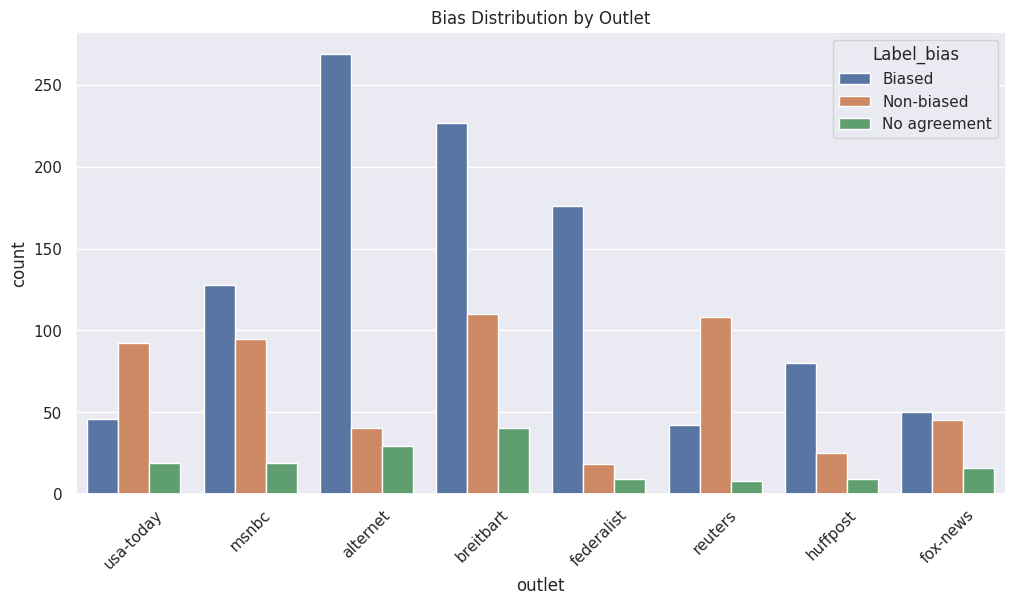

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='outlet', hue='Label_bias', data=df)
plt.title('Bias Distribution by Outlet')
plt.xticks(rotation=45)
plt.show()

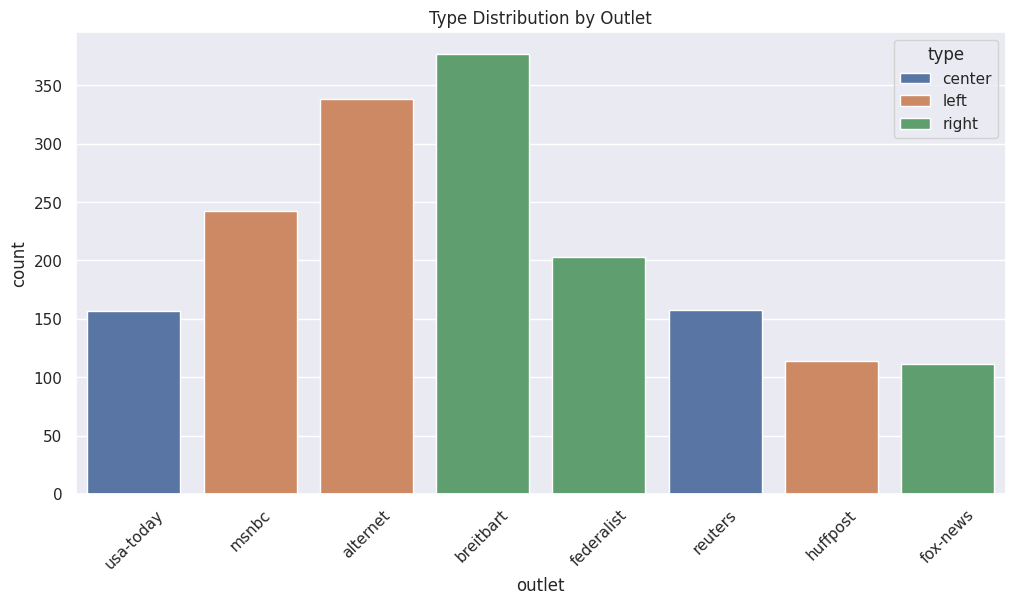

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='outlet', hue='type', data=df)
plt.title('Type Distribution by Outlet')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.drop(["outlet"], axis = 1)

,sentence,type,Label_bias,article,Processed Sentence,Processed Article
0,YouTube is making clear there will be no “birt...,center,Biased,YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[youtube, says, no, ‘, deepfakes, ’, or, ‘, bi..."
1,The increasingly bitter dispute between Americ...,left,Non-biased,"FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[frisco, ,, texas, —, the, increasingly, bitte..."
2,So while there may be a humanitarian crisis dr...,left,Biased,Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[speaking, to, the, country, for, the, first, ..."
3,A professor who teaches climate change classes...,right,Non-biased,A professor who teaches climate change classes...,"[a, professor, who, teaches, climate, change, ...","[a, professor, who, teaches, climate, change, ..."
4,"Looking around the United States, there is nev...",right,Biased,The left has a thing for taking babies hostage...,"[looking, around, the, united, states, ,, ther...","[the, left, has, a, thing, for, taking, babies..."
...,...,...,...,...,...,...
1695,In every case legislators are being swarmed by...,left,Biased,There are many reasons that Republicans and co...,"[in, every, case, legislators, are, being, swa...","[there, are, many, reasons, that, republicans,..."
1696,Polls show the transgender ideology is deeply ...,right,Biased,A man’s penis becomes a female penis once a ma...,"[polls, show, the, transgender, ideology, is, ...","[a, man, ’, s, penis, becomes, a, female, peni..."
1697,Democrats and Republicans stood and applauded ...,center,Non-biased,NaN,"[democrats, and, republicans, stood, and, appl...",
1698,"As a self-described Democratic socialist, Sen....",right,Non-biased,"As a self-described Democratic socialist, Sen....","[as, a, self-described, democratic, socialist,...","[as, a, self-described, democratic, socialist,..."


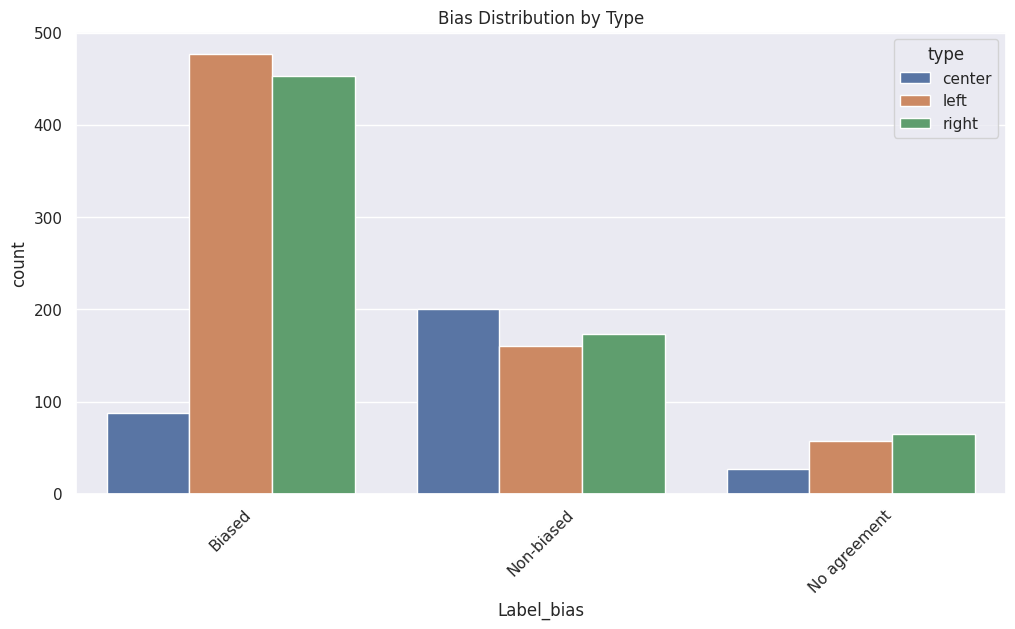

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Label_bias', hue='type', data=df)
plt.title('Bias Distribution by Type')
plt.xticks(rotation=45)
plt.show()

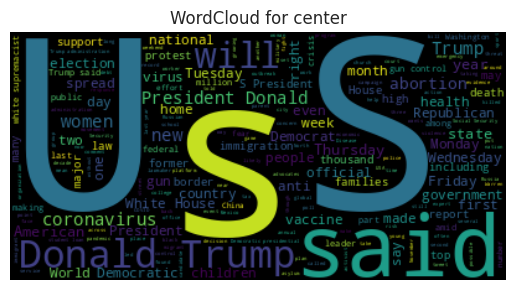

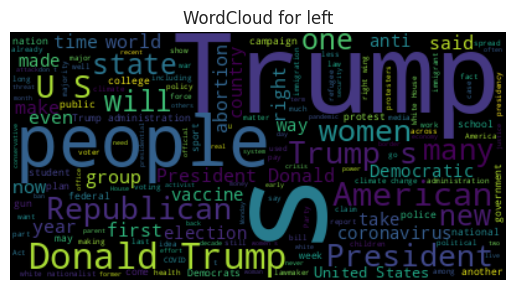

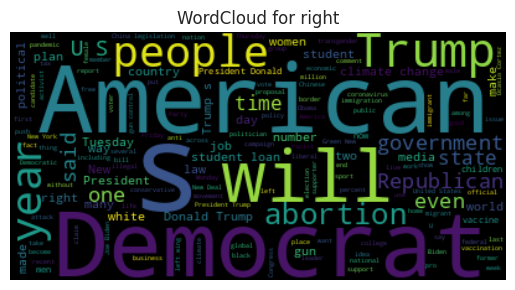

In [ ]:
def get_wordcloud(types):
    species_data = df[df['type'] == types]
    text = ' '.join(species_data['sentence'].tolist())
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {types}')
    plt.show()

types_list = df['type'].unique()
for typess in types_list:
    get_wordcloud(typess)

In [ ]:
df['type']=df['type'].map({'left':-1,'center':0, 'right':1})
df

,sentence,outlet,type,Label_bias,article,Processed Sentence,Processed Article
0,YouTube is making clear there will be no “birt...,usa-today,0,Biased,YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[youtube, says, no, ‘, deepfakes, ’, or, ‘, bi..."
1,The increasingly bitter dispute between Americ...,msnbc,-1,Non-biased,"FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[frisco, ,, texas, —, the, increasingly, bitte..."
2,So while there may be a humanitarian crisis dr...,alternet,-1,Biased,Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[speaking, to, the, country, for, the, first, ..."
3,A professor who teaches climate change classes...,breitbart,1,Non-biased,A professor who teaches climate change classes...,"[a, professor, who, teaches, climate, change, ...","[a, professor, who, teaches, climate, change, ..."
4,"Looking around the United States, there is nev...",federalist,1,Biased,The left has a thing for taking babies hostage...,"[looking, around, the, united, states, ,, ther...","[the, left, has, a, thing, for, taking, babies..."
...,...,...,...,...,...,...,...
1695,In every case legislators are being swarmed by...,alternet,-1,Biased,There are many reasons that Republicans and co...,"[in, every, case, legislators, are, being, swa...","[there, are, many, reasons, that, republicans,..."
1696,Polls show the transgender ideology is deeply ...,breitbart,1,Biased,A man’s penis becomes a female penis once a ma...,"[polls, show, the, transgender, ideology, is, ...","[a, man, ’, s, penis, becomes, a, female, peni..."
1697,Democrats and Republicans stood and applauded ...,usa-today,0,Non-biased,NaN,"[democrats, and, republicans, stood, and, appl...",
1698,"As a self-described Democratic socialist, Sen....",fox-news,1,Non-biased,"As a self-described Democratic socialist, Sen....","[as, a, self-described, democratic, socialist,...","[as, a, self-described, democratic, socialist,..."


In [ ]:
df['Label_bias']=df['Label_bias'].map({'Biased':1, 'Non-biased':0})
df

,sentence,outlet,type,Label_bias,article,Processed Sentence,Processed Article
0,YouTube is making clear there will be no “birt...,usa-today,0,1.0,YouTube says no ‘deepfakes’ or ‘birther’ video...,"[youtube, is, making, clear, there, will, be, ...","[youtube, says, no, ‘, deepfakes, ’, or, ‘, bi..."
1,The increasingly bitter dispute between Americ...,msnbc,-1,0.0,"FRISCO, Texas — The increasingly bitter disput...","[the, increasingly, bitter, dispute, between, ...","[frisco, ,, texas, —, the, increasingly, bitte..."
2,So while there may be a humanitarian crisis dr...,alternet,-1,1.0,Speaking to the country for the first time fro...,"[so, while, there, may, be, a, humanitarian, c...","[speaking, to, the, country, for, the, first, ..."
3,A professor who teaches climate change classes...,breitbart,1,0.0,A professor who teaches climate change classes...,"[a, professor, who, teaches, climate, change, ...","[a, professor, who, teaches, climate, change, ..."
4,"Looking around the United States, there is nev...",federalist,1,1.0,The left has a thing for taking babies hostage...,"[looking, around, the, united, states, ,, ther...","[the, left, has, a, thing, for, taking, babies..."
...,...,...,...,...,...,...,...
1695,In every case legislators are being swarmed by...,alternet,-1,1.0,There are many reasons that Republicans and co...,"[in, every, case, legislators, are, being, swa...","[there, are, many, reasons, that, republicans,..."
1696,Polls show the transgender ideology is deeply ...,breitbart,1,1.0,A man’s penis becomes a female penis once a ma...,"[polls, show, the, transgender, ideology, is, ...","[a, man, ’, s, penis, becomes, a, female, peni..."
1697,Democrats and Republicans stood and applauded ...,usa-today,0,0.0,NaN,"[democrats, and, republicans, stood, and, appl...",
1698,"As a self-described Democratic socialist, Sen....",fox-news,1,0.0,"As a self-described Democratic socialist, Sen....","[as, a, self-described, democratic, socialist,...","[as, a, self-described, democratic, socialist,..."


In [ ]:
# Ensure that all entries in 'Processed Sentence' are strings by joining lists, if any
df['Processed Sentence'] = df['Processed Sentence'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Now apply the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Processed Sentence' column
X_sentence = vectorizer.fit_transform(df['Processed Sentence'])

# Similarly for 'Processed Article'
df['Processed Article'] = df['Processed Article'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
X_article = vectorizer.fit_transform(df['Processed Article'])


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])

X_combined = hstack([X_sentence, X_article])

X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=37)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=37)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=2, class_weight='balanced')

# Train the model
rfc.fit(X_train, y_train)

# Predict using the trained model
y_pred0 = rfc.predict(X_val)

# Calculate the accuracy based on the combined labels
accuracy = accuracy_score(y_val, y_pred0)
print(f'Validation Accuracy: {accuracy}')

# Optionally, you can print the classification report as well
print(classification_report(y_val, y_pred0))

Validation Accuracy: 0.8823529411764706
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.94      0.80      0.87        61
           2       0.79      0.96      0.87       135

    accuracy                           0.88       340
   macro avg       0.90      0.87      0.88       340
weighted avg       0.90      0.88      0.88       340



In [ ]:
scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scori|ng metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

Cross-Validation Scores (Accuracy): [0.84131737 0.8502994  0.89221557 0.91591592 0.90990991]
Mean CV Score: 0.8819316322310335
Cross-Validation Scores (F1-Macro): [0.84530313 0.85358536 0.89193833 0.91564769 0.90780045]
Mean CV Score: 0.882854992981866


In [ ]:
lr = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred1 = lr.predict(X_val)
print("Accuracy: "+str(accuracy_score(y_val,y_pred1)))
print(classification_report(y_val, y_pred1))

Accuracy: 0.8705882352941177
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       144
           1       0.87      0.79      0.83        61
           2       0.85      0.90      0.88       135

    accuracy                           0.87       340
   macro avg       0.87      0.86      0.86       340
weighted avg       0.87      0.87      0.87       340



In [ ]:
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

Cross-Validation Scores (Accuracy): [0.8742515  0.86227545 0.88622754 0.92192192 0.90690691]
Mean CV Score: 0.8903166639693586
Cross-Validation Scores (F1-Macro): [0.87475215 0.86264895 0.88519418 0.92115005 0.90570218]
Mean CV Score: 0.8898895019595319


In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred2 = svc.predict(X_val)
print("Accuracy: "+str(accuracy_score(y_val,y_pred2)))
print(classification_report(y_val, y_pred2))

Accuracy: 0.9147058823529411
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       144
           1       0.86      0.90      0.88        61
           2       0.93      0.90      0.92       135

    accuracy                           0.91       340
   macro avg       0.90      0.91      0.91       340
weighted avg       0.92      0.91      0.91       340



In [ ]:
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

Cross-Validation Scores (Accuracy): [0.93413174 0.88922156 0.90718563 0.95795796 0.91291291]
Mean CV Score: 0.9202819586053119
Cross-Validation Scores (F1-Macro): [0.93410515 0.88934038 0.90675263 0.95773365 0.91200746]
Mean CV Score: 0.919987852980517


In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred3 = mnb.predict(X_val)
print("Accuracy: "+str(accuracy_score(y_val,y_pred3)))
print(classification_report(y_val, y_pred3))

Accuracy: 0.7647058823529411
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       144
           1       1.00      0.31      0.47        61
           2       0.72      0.93      0.81       135

    accuracy                           0.76       340
   macro avg       0.84      0.68      0.69       340
weighted avg       0.80      0.76      0.74       340



In [ ]:
scores = cross_val_score(mnb, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(mnb, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

Cross-Validation Scores (Accuracy): [0.72155689 0.71556886 0.83532934 0.87687688 0.87387387]
Mean CV Score: 0.804641168114222
Cross-Validation Scores (F1-Macro): [0.70944738 0.70376241 0.83760182 0.87818155 0.87601173]
Mean CV Score: 0.8010009766504538


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, max_features='sqrt', max_depth=4, random_state=37, verbose=0)

# Train the model
gbc.fit(X_train, y_train)

# Predict using the trained model
y_pred5 = gbc.predict(X_val)

# Print the accuracy and classification report
print(accuracy_score(y_val, y_pred5))
print(classification_report(y_val, y_pred5))

0.9029411764705882
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       144
           1       0.93      0.87      0.90        61
           2       0.86      0.94      0.90       135

    accuracy                           0.90       340
   macro avg       0.91      0.90      0.90       340
weighted avg       0.91      0.90      0.90       340



In [ ]:
scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

Cross-Validation Scores (Accuracy): [0.88922156 0.86826347 0.90419162 0.92192192 0.92792793]
Mean CV Score: 0.9023052993112873
Cross-Validation Scores (F1-Macro): [0.88992399 0.86871383 0.90411853 0.921342   0.92706767]
Mean CV Score: 0.9022332032297153


In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=37)
abc= AdaBoostClassifier(estimator=rfc, learning_rate=0.05, n_estimators=100)
abc.fit(X_train, y_train)
y_pred7= abc.predict(X_val)
print("Accuracy: "+str(accuracy_score(y_val, y_pred7)))
print(classification_report(y_val, y_pred7))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8970588235294118
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       144
           1       0.96      0.84      0.89        61
           2       0.81      0.97      0.88       135

    accuracy                           0.90       340
   macro avg       0.92      0.89      0.90       340
weighted avg       0.91      0.90      0.90       340



In [ ]:
scores = cross_val_score(abc, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(abc, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Cross-Validation Scores (Accuracy): [0.88023952 0.86227545 0.91317365 0.93993994 0.91291291]
Mean CV Score: 0.9017082951214688


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Cross-Validation Scores (F1-Macro): [0.8826546  0.8709566  0.91935955 0.93325235 0.90412246]
Mean CV Score: 0.9020691124648156


In [ ]:
Comparison_unibi = pd.DataFrame({'Logistic Regression': [accuracy_score(y_val,y_pred1)*100,f1_score(y_val,y_pred1,average='macro')*100,recall_score(y_val, y_pred1,average='micro')*100,precision_score(y_val, y_pred1,average='micro')*100],
                            'SVM':[accuracy_score(y_val,y_pred2)*100,f1_score(y_val,y_pred2,average='macro')*100,recall_score(y_val, y_pred2,average='micro')*100,precision_score(y_val, y_pred2,average='micro')*100],
                           'Naive Bayes':[accuracy_score(y_val,y_pred3)*100,f1_score(y_val,y_pred3,average='macro')*100,recall_score(y_val, y_pred3,average='micro')*100,precision_score(y_val, y_pred3,average='micro')*100],
                           'Random Forest':[accuracy_score(y_val,y_pred0)*100,f1_score(y_val,y_pred0,average='macro')*100,recall_score(y_val, y_pred0,average='micro')*100,precision_score(y_val, y_pred0,average='micro')*100],
                           'GradientBoosting':[accuracy_score(y_val,y_pred5)*100,f1_score(y_val,y_pred5,average='macro')*100,recall_score(y_val, y_pred5,average='micro')*100,precision_score(y_val, y_pred5,average='micro')*100],
                          #  'Ensembled':[accuracy_score(y_val,y_pred6)*100,f1_score(y_val,y_pred6,average='macro')*100,recall_score(y_val, y_pred6,average='micro')*100,precision_score(y_val, y_pred6,average='micro')*100],
                           'Adaboost':[accuracy_score(y_val,y_pred7)*100,f1_score(y_val,y_pred7,average='macro')*100,recall_score(y_val, y_pred7,average='micro')*100,precision_score(y_val, y_pred7,average='micro')*100],
})


Comparison_unibi.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_unibi.head()


,Logistic Regression,SVM,Naive Bayes,Random Forest,GradientBoosting,Adaboost
Accuracy,89.411765,91.470588,76.470588,88.235294,90.294118,89.705882
F1_score,88.885826,90.820962,69.373629,88.003055,90.207528,89.712996
Recall,89.411765,91.470588,76.470588,88.235294,90.294118,89.705882
Precision,89.411765,91.470588,76.470588,88.235294,90.294118,89.705882


In [ ]:
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=37)
lr = LogisticRegression(C=1, max_iter=1000, n_jobs=-1)
svc = SVC(probability=True)
gbc = GradientBoostingClassifier(n_estimators=100, max_features='sqrt', max_depth=4, random_state=37, verbose=0)
abc= AdaBoostClassifier(estimator=rfc, learning_rate=0.05, n_estimators=100)

total_f1 = 88.885826+	90.820962+	69.373629+	88.003055+	90.207528+	89.712996
weights = {
        'Logistic Regression': 89.41 / total_f1,
        'SVM': 91.47 / total_f1,
        'Naive Bayes': 76.47 / total_f1,
        'Random Forest': 88.23 / total_f1,
        'AdaBoost': 89.705 / total_f1,
        'GradientBoosting': 90.294 / total_f1
    }
ec = VotingClassifier(
    estimators=[
        ('Multinominal NB', mnb),
        ('Random Forest', rfc),
        ('Logistic Regression', lr),
        ('Support Vector Machine', svc),
        ('GradientBoosting', gbc),
        ('Adaboost Random Forest', abc)
    ],
    voting='soft',

    weights = [weights['Naive Bayes'], weights['Random Forest'], weights['Logistic Regression'], weights['SVM'],weights['GradientBoosting'], weights['AdaBoost']]
)

# Fit the VotingClassifier
ec.fit(X_train, y_train)

# Predict and evaluate
y_pred6 = ec.predict(X_val)
print(accuracy_score(y_val, y_pred6))
print(classification_report(y_val, y_pred6))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.9205882352941176
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       144
           1       0.98      0.85      0.91        61
           2       0.90      0.94      0.92       135

    accuracy                           0.92       340
   macro avg       0.93      0.91      0.92       340
weighted avg       0.92      0.92      0.92       340



In [ ]:
scores = cross_val_score(ec, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# You can also use other scoring metrics like F1 (replace 'accuracy' with 'f1_macro')
f1_scores = cross_val_score(ec, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Cross-Validation Scores (Accuracy): [0.86526946 0.87125749 0.91616766 0.94594595 0.93693694]
Mean CV Score: 0.9071154987322652


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
print("Mean CV Score:", f1_scores.mean())

Mean CV Score: 0.908973840666628


In [ ]:
hgbc = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=200,
    max_leaf_nodes=50,
    l2_regularization=1.0,
    random_state=37
)

hgbc.fit(X_train.toarray(), y_train)

y_pred8 = hgbc.predict(X_val.toarray())

# Evaluate the performance
print("Accuracy: " + str(accuracy_score(y_val, y_pred8)))
print(classification_report(y_val, y_pred8))

Accuracy: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       144
           1       0.97      0.93      0.95        61
           2       0.91      0.95      0.93       135

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340



In [ ]:
pickle.dump(hgbc, open('hgbc.pkl', 'wb'))

NameError: name 'hgbc' is not defined

In [ ]:
loaded_model = pickle.load(open('hgbc.pkl', 'rb'))

In [ ]:
y_pred8 = loaded_model.predict(X_val.toarray())

# Evaluate the performance
print("Accuracy: " + str(accuracy_score(y_val, y_pred8)))
print(classification_report(y_val, y_pred8))

Accuracy: 0.9411764705882353
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       144
           1       0.97      0.93      0.95        61
           2       0.91      0.95      0.93       135

    accuracy                           0.94       340
   macro avg       0.95      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340



In [ ]:
# Convert sparse matrix to dense array
X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train

# Fit the model and perform cross-validation
scores = cross_val_score(hgbc, X_train_dense, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", scores)
print("Mean CV Score:", scores.mean())

# F1-macro scoring
f1_scores = cross_val_score(hgbc, X_train_dense, y_train, cv=5, scoring='f1_macro')
print("Cross-Validation Scores (F1-Macro):", f1_scores)
print("Mean CV Score:", f1_scores.mean())


KeyboardInterrupt: 

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

# Instantiate the LGBMClassifier
lgb_m = lgb.LGBMClassifier(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=8,              # Reduce tree depth to avoid overfitting
    num_leaves=20,            # Restrict number of leaves
    min_data_in_leaf=30,      # Minimum number of samples in a leaf
    min_split_gain=0.0001,    # Set minimum split gain to encourage splitting
    force_col_wise=True,      # Use column-wise processing for sparse data
    random_state=37,
)


lgb_m.fit(X_train, y_train)

y_pred9 = lgb_m.predict(X_val.toarray())

# Evaluate the performance
print("Accuracy: " + str(accuracy_score(y_val, y_pred9)))
print(classification_report(y_val, y_pred9))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 128277
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 3603
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Create a LightGBM classifier
lgb_m = lgb.LGBMClassifier()

# Define the hyperparameters grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.05],  # Learning rate
    'n_estimators': [100, 500, 1000],    # Number of boosting rounds
    'num_leaves': [31, 50, 100],         # Number of leaves in one tree
    'max_depth': [3, 5, 10],             # Max depth of the tree
    'min_data_in_leaf': [20, 30, 50],    # Minimum number of data in one leaf
    'feature_fraction': [0.8, 0.9, 1.0], # Fraction of features to use
    'bagging_fraction': [0.8, 0.9, 1.0], # Fraction of data to use for boosting
    'lambda_l1': [0, 1],                 # L1 regularization
    'lambda_l2': [0, 1],                 # L2 regularization
}

# Set up the grid search
grid_search = GridSearchCV(
    estimator=lgb_m,
    param_grid=param_grid,
    scoring='accuracy',   # You can use other metrics like 'roc_auc', 'f1', etc.
    cv=5,                 # Number of cross-validation folds
    verbose=1,            # Increase verbosity for more details
    n_jobs=-1             # Use all CPU cores
)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the model with the test set
y_pred = grid_search.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


Fitting 5 folds for each of 8748 candidates, totalling 43740 fits


KeyboardInterrupt: 

In [ ]:
# Create separate vectorizers for sentence and article
vectorizer_sentence = TfidfVectorizer()
vectorizer_article = TfidfVectorizer()

# Fit and transform the 'Processed Sentence' and 'Processed Article' columns separately
X_sentence = vectorizer_sentence.fit_transform(df['Processed Sentence'])
X_article = vectorizer_article.fit_transform(df['Processed Article'])

# Combine the features
X_combined = hstack([X_sentence, X_article])

In [ ]:
def predict_headline(input_sentence, input_article, vectorizer_sentence, vectorizer_article, trained_model, label_encoder):
    # Transform the input sentence and article using the separate vectorizers
    transformed_sentence = vectorizer_sentence.transform([input_sentence])
    transformed_article = vectorizer_article.transform([input_article])

    # Combine the sentence and article features
    X_combined = hstack([transformed_sentence, transformed_article])

    # Predict the class using the trained model
    prediction = trained_model.predict(X_combined.toarray())

    # Decode the predicted label back to the original class
    predicted_label = label_encoder.inverse_transform(prediction)

    return predicted_label

# Example usage:
input_sentence = """Obama’s reemergence on the campaign trail for Harris comes as he recognizes his own legacy is at stake"""

input_article = """
America and the world have a lot riding on who wins in November. So does Barack Obama.
And that’s part of what is powering what people familiar with Obama’s plans told CNN will be the most active closing weeks of an election the former president’s had since his own last campaign. More rallies are coming every week. This past Wednesday alone, he recorded 21 videos for the Harris campaign. More ads for Democratic Senate candidates are already in the can. Content with influencers will keep popping online. He’ll even be doing a few interviews of his own.
This is on top of a range of meetings and phone calls Obama has held over the last year with Kamala Harris, Joe Biden and other top Democrats, first reported by CNN, as advisers, friends and political allies say the former president has become increasingly alarmed by Donald Trump’s continued hold on the country and its politics.
Obama no longer thinks he can get to the people locked in with Trump.
He’s just hoping to help find enough votes in enough states to counter them.
Former President Barack Obama speaks during a campaign rally supporting Democratic presidential nominee Vice President Kamala Harris at the University of Pittsburgh's Fitzgerald Field House in Pittsburgh, Pennsylvania, on October 10, 2024.
analysis
Obama, the ‘hopey-changey guy,’ tries to close the deal for Harris
If the vice president wins, Obama will feel vindicated, and in many ways, will be released to more of the post-presidency he’d been hoping for since right before he called to congratulate Trump on election night 2016 — the first time (and ultimately one of the few times) the two spoke.
But a thought has circulated among several people close to the former president, they told CNN: If Trump wins, Obama might be seen as the aberration in the history of American politics, rather than Trump and his nativist authoritarianism. Obama acolytes have spent the last eight years rationalizing Trump as the last gasp backlash to the Democrat and his presidency.
Obama always wanted to stay involved in politics, just more as an emeritus elder steering what came after him, without as many rallies and constant calls to swoop in and save the party. He would like to see his theory proved true that stepping back wasn’t just about making money off of podcasting with Bruce Springsteen or narrating a documentary series about parks for Netflix — as some resentful Democrats came to feel — but about letting new people emerge without his shadow.
“The goal has always been to pass the torch to the next generation of leaders to ensure the party is sustainable long term without him,” said Hannah Hankins, a spokesperson for the former president who first worked for him in the White House.
All that and the survival of much of what he put in place as president depends on his main mission for the fall: breaking through to  young Black men, as he is uniquely situated to do, hoping they don’t give up on the Democratic Party in the high numbers that even internal Harris-aligned campaign polling show may be happening.
That poured out of Obama on Thursday, when ahead of his first campaign rally in Pittsburgh, he turned what was supposed to be a perfunctory stop by a Harris office into a visceral calling out of young Black men for “coming up with all kinds of reasons and excuses” for not supporting Harris, abandoning their communities and themselves. He said he feared that they are either being fooled by Trump or “you just aren’t feeling the idea of having a woman as president.”
Obama can still draw a crowd. A dozen of the 4,500 people packing a gym on the University of Pittsburgh campus on Thursday night told CNN in interviews that they still feel connected to him — including a 15-year-old named Kai Jones, wearing a T-shirt printed with the famous photo of Obama and Biden jogging through the Rose Garden. Jones, who wasn’t yet born in 2008, said Obama “has a special place in my heart.”
But if the question remains: Can Obama draw in those young Black men? On Thursday in Pittsburgh, there weren’t as many of those faces in the crowd.
“The fact that he has not been in the day-to-day political scene, people don’t see him in the partisan muck that everybody else,” Austin Davis, the Pennsylvania lieutenant governor and a 35-year-old Black man himself, told CNN ahead of the rally. “You have to think about the type of people who naturally show up to political rallies. It’s not just the crowd here, it’s the crowd that’s watching at home.”
Campaign strategy meetings and advice on Washington
Most of the Democratic work Obama has been doing the last few years has been behind the scenes. A lot has been with Hakeem Jeffries, the New York congressman hoping to become the next speaker of the House whose connection to the former president runs so deep that, as he sometimes points out, he has the same birthday and his wife is also named Michelle.
After their own one-on-one meeting, Obama asked Jeffries to suggest a few small groups of Democratic House members for trips to his office in the World Wildlife Federation in northwest Washington. The members ranged from New York Rep. Alexandria Ocasio-Cortez to much lesser known and less progressive up-and-comers, like Washington Rep. Marie Gluesenkamp Perez and Alaska Rep. Mary Peltola. He talked to them about coming off like real people rather than scolding coastal elites and staying consistent rather than being pulled into the whirlwind of Washington consultant advice, according to people in the room.
Former US President and Republican presidential candidate Donald Trump looks on during a campaign rally in Butler, Pennsylvania on October 5, 2024.
As Trump delays transition process, Biden and Harris teams push forward with post-election planning
Several took written notes, including a nervous congressman who watched Obama play with an aide’s child before their meeting started and wrote down to focus on learning how to charm babies, according to one of the people who saw it.
Obama’s session last November with Senate Majority Leader Chuck Schumer and the incumbent Democratic senators running in 2024 was more focused on briefing Obama on their races so he could better understand their challenges and offer support.
“It was great to be able to begin the strategy with him,” said Pennsylvania Sen. Bob Casey, whom Obama has liked since they were in the Senate together and whom the former president insisted be seated onstage to be in the shot with him throughout Thursday’s rally in Pittsburgh.
Casey later came by for his own separate meeting, as did Reps. Elissa Slotkin and Ruben Gallego, the Democratic Senate nominees in Michigan and Arizona. The list goes on and includes Pennsylvania Gov. Josh Shapiro, who stopped by a year before he became an Obama world favorite in this summer’s running mate search for Harris.
Campaigning in Pennsylvania a few hours before heading to Obama’s speech Thursday, though, Arizona Sen. Mark Kelly said he’s ready to step forward and help pull Harris and other Democrats over the line.
Asked whether he was ready to see Obama hold to his theory of turning over to the next generation of Democrats, Kelly said, “Not yet.”
Navigating Biden and coming around on Harris
Obama had hoped to start stepping back when Biden won. Neither president was thrilled with how the last few years played out between them.
Long before Biden’s dismal debate in June, the president had been complaining privately that Obama wasn’t helping enough, according to several people who spoke to Biden. Biden aides sensed a jealousy from Obama’s orbit that they were racking up more accomplishments than he had, with senior adviser Mike Donilon saying once in private conversation, “They need to get over it,” according to one of the people who heard it — and Biden aides hated the Republican conspiracy theory that Obama was actually pulling the strings.
For over a year, when Biden wanted a former president sounding board, he was ringing up Bill Clinton instead.
After Biden’s debate debacle, diehards burned that Obama had left the president to twist in the wind when he could have more forcefully ended the questions, while many Democrats suffering through that month felt he was going feckless again. Many calls came in.
Biden’s dropping out sparked its own Obama drama, and not just because the president’s immediate endorsement of Harris came with the added benefit of demonstrating a deference he often complained he never got from his old boss. While most of the party leaders Harris called that Sunday afternoon, including Bill Clinton, immediately pledged support, Obama held off. He offered advice and encouragement but told her he wanted to make sure the process was seen as legitimate in a way it might not have if he had jumped out early.
Harris advisers knew Obama and former House Speaker Nancy Pelosi favored an open process to find a new nominee. What some couldn’t figure out was how much of that was Obama’s doubts and disappointments about Harris from her 2019 campaign and early vice presidency shining through, and how much was a political calculation that she would be better off if she emerged after a process rather than a coronation
Former President Bill Clinton speaks at the DNC on Wednesday, August 21, in Chicago.
Related article
Bill Clinton to hit battleground states for Harris
Several people familiar with Obama’s thinking said that he thought she was in the strongest position starting out, but he believed others would run — and that he was pleased to see her talking that week about earning the nomination even as others didn’t. When the Obamas called Harris that Wednesday to officially endorse, his argument was that he was acting as the closer, certifying party unity, even as some outsiders complained it looked like he had held out as long as he could.
Obama and Biden have spoken once since the president dropped out. Obama initiated the conversation, telling aides to let the White House know he was eager for a call whenever Biden had time, and they soon spoke. It wasn’t the two presidents’ deepest or longest conversation. Obama said he appreciated all that Biden had done as president, and how hard stepping aside was. He said he loved him like a brother and always would. Biden took the call to heart, without hard feelings. He thanked Obama for reaching out.
Obama has had several conversations with Harris, whom he first got to know through an informal network of up-and-coming Black politicians when he was a state senator and she was a district attorney. One centered entirely on her running mate selection, though he was giving his take on how she should approach the process rather than weighing in for one candidate. Others have been to help guide her through everything from staffing decisions to bigger picture strategy. And according to people who know about the conversations, he checks in with several of his own closest aides now helping run Harris’ campaign, such as current campaign chair Jen O’Malley Dillon and his own 2008 campaign manager, David Plouffe.
In both public and in private conversations, Obama has heaped praise on Harris for the way she’s campaigned and what she’s campaigning on
Meanwhile, conversations are underway to get Michelle Obama to carry through with her own “do something” speech from August’s Democratic National Convention. She’s expected to do an event or two — but not much more than that.
‘He doesn’t feel like history’
Standing in the gym waiting for Obama, Paige Mirsky, a 24-year-old biochemistry graduate student originally from Buffalo, said that part of the reason she was there was because watching his convention speech “made me want to actually do something.”
“He feels like the future,” she said.
She acknowledged that she had been all of 8 when Obama first won, that she hadn’t been steeped in the details of his record in office, and that he has been out of the White House a long time already.
Obama’s leaving office was “a turning point,” Mirsky said. “That was the last time anybody felt normal.”
A few feet over, a 64-year-old physics professor named Eric Swanson who had grown up in Canada before becoming a US citizen said that watching Obama in Grant Park on election night 2008 was “the only time I felt proud to be an American.”
He said he’s hoping to feel that same feeling with Harris. He doesn’t feel it yet. Maybe, Swanson said, Obama would get him there.
A clump of Pitt freshmen found spots in the middle of the floor, waving to friends and making sure they’d still have the sight lines right to the man himself.
“My parents talk about him a lot,” Amelia Staresink said, explaining why she felt connected to a president who had left office when they were in fourth grade.
Democratic presidential nominee Vice President Kamala Harris walks to board Air Force Two as she departs for New York, at Joint Base Andrews, Maryland, on October 7, 2024.
"""
predicted_type = predict_headline(input_sentence, input_article, vectorizer_sentence, vectorizer_article, loaded_model, label_encoder)

type_mapping = {
    -1: 'left',
    0: 'center',
    1: 'right'
}

# Apply the mapping to your 'type' column
mapped_type = type_mapping[predicted_type[0]]

print("The headline is classified as:", mapped_type)
print("The headline is classified as:", predicted_type)

The headline is classified as: left
The headline is classified as: [-1]
